# 0. importing data & liberaries

In [1]:
from pathlib import Path
from zipfile import ZipFile

data_path = Path('data/') / 'food'

if not data_path.is_dir():
    data_path.mkdir(exist_ok=True, parents=True)

    with ZipFile("/content/drive/MyDrive/food.zip", mode='r') as f:
        f.extractall(data_path)

In [2]:
!pip install torchinfo
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 5.9 MB/s eta 0:00:00


In [47]:
import torch
import torch.nn as nn
import torchvision
import torchmetrics
import torchinfo
import os
import random
import PIL.Image as Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. checking the data

In [5]:
def walk_in_data(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there is {len(dirnames):2} dirrectories and {len(filenames):4} in {dirpath}")

walk_in_data(data_path)

there is  1 dirrectories and    0 in data/food
there is  2 dirrectories and    0 in data/food/food
there is  0 dirrectories and 4276 in data/food/food/test
there is 21 dirrectories and    0 in data/food/food/train
there is  0 dirrectories and  779 in data/food/food/train/cheesecake
there is  0 dirrectories and  786 in data/food/food/train/french_fries
there is  0 dirrectories and  817 in data/food/food/train/hot_dog
there is  0 dirrectories and  805 in data/food/food/train/ice_cream
there is  0 dirrectories and  781 in data/food/food/train/steak
there is  0 dirrectories and  790 in data/food/food/train/sushi
there is  0 dirrectories and  809 in data/food/food/train/falafel
there is  0 dirrectories and  787 in data/food/food/train/pizza
there is  0 dirrectories and  802 in data/food/food/train/chocolate_cake
there is  0 dirrectories and  807 in data/food/food/train/chicken_curry
there is  0 dirrectories and  795 in data/food/food/train/donuts
there is  0 dirrectories and  815 in data/fo

In [6]:
data_path

PosixPath('data/food')

In [7]:
train_dir = data_path / 'food/train'
test_dir  = data_path / 'food/test'

caesar_salad
512 512


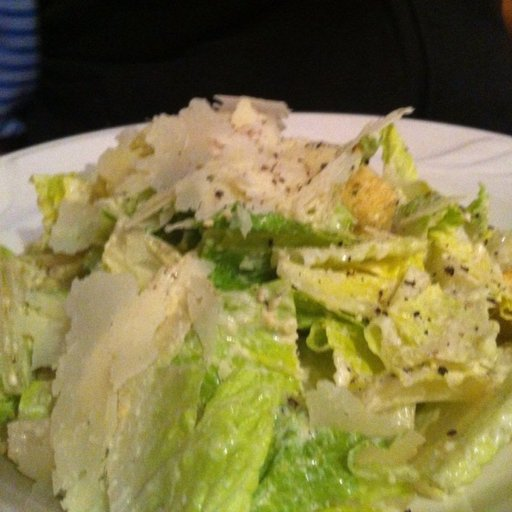

In [8]:
def show_random_image(data_path):
    data_path_list = list(data_path.glob('*/train/*/*.jpg'))
    random_image_path = random.choice(data_path_list)
    class_name = random_image_path.parent.stem
    # image = Image.open(random_image_path)

    return (random_image_path, class_name)

image, label = show_random_image(data_path)
image = Image.open(image)
print(label)
print(image.height, image.width)
image

In [9]:
np.asarray(image).shape

(512, 512, 3)

# 2. creating datasets and dataloaders

In [10]:
weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
weights

EfficientNet_V2_L_Weights.IMAGENET1K_V1

In [11]:
data = torchvision.datasets.ImageFolder(root=train_dir,
                                        transform=weights.transforms())

In [12]:
train_data, test_data = torch.utils.data.random_split(dataset=data,
                                                      lengths=[10500, 7052])

In [13]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=os.cpu_count(),
                                               pin_memory=True)

test_dataloader  = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=32,
                                               shuffle=False,
                                               num_workers=os.cpu_count(),
                                               pin_memory=True)

In [14]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([32, 3, 480, 480]), torch.Size([32]))

# 3. Getting a pre-trained model

## 3.1. Defining the model

In [15]:
model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 164MB/s]


In [16]:
torchinfo.summary(model=model,
                  input_size=image.shape,
                  col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 480, 480]         [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 3, 480, 480]         [32, 1280, 15, 15]        --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 480, 480]         [32, 32, 240, 240]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 480, 480]         [32, 32, 240, 240]        864                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 240, 240]        [32, 32, 240, 240]        64                        True
│    │    └─SiLU: 3-3                                   [32, 32, 240, 240]        [32, 32, 240, 240]        --                        --
│    └─Sequential: 2-2  

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## 3.2. Freezing feature layers

In [18]:
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
model.classifier = nn.Sequential(nn.Dropout(p=0.4, inplace=True),
                                 nn.Linear(in_features=1280, out_features=len(data.classes))).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=21, bias=True)
)

In [20]:
torchinfo.summary(model=model,
                  input_size=image.shape,
                  col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 480, 480]         [32, 21]                  --                        Partial
├─Sequential: 1-1                                       [32, 3, 480, 480]         [32, 1280, 15, 15]        --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 480, 480]         [32, 32, 240, 240]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 480, 480]         [32, 32, 240, 240]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 240, 240]        [32, 32, 240, 240]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 240, 240]        [32, 32, 240, 240]        --                        --
│    └─Sequential

# 4. Training the model

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               device: torch.device,
               acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy):

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_logit = model(X)
        y_preds = torch.argmax(torch.softmax(y_logit, axis=1), axis=1)

        # 2. calc loss
        loss = loss_fn(y_logit, y)
        acc  = acc_fn(y_preds, y)

        train_loss += loss
        train_acc += acc

        # 3. opt zero grad
        opt.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5.gradient descent
        opt.step()

        if batch % 100 == 0:
            print(f"\t\t  seen {batch} / {len(dataloader)}")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy):

    model.eval()

    test_loss, test_acc = 0, 0


    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            y_logit = model(X)
            y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)

            # 2. calc loss
            loss = loss_fn(y_logit, y)
            acc = acc_fn(y_pred, y)

            test_loss += loss
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

In [23]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
          opt: torch.optim.Optimizer,
          device: torch.device,
          epochs: int):

    model.to(device)

    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    for epoch in tqdm(range(epochs)):
        print(f'epoch #{epoch:3}:')
        t0 = timer()

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           opt=opt,
                                           device=device,
                                           acc_fn=acc_fn)

        test_loss, test_acc  =   test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          device=device,
                                          acc_fn=acc_fn)

        print(
            # "",
            # f"epoch #{epoch:3} --> ",
            '\t',
            f"train loss: {train_loss:2.4f}, ",
            f"train acc: {train_acc:2.4f} | ",
            f"test loss: {test_loss:2.4f}, ",
            f"test acc {test_acc:2.4f} |",
            f"time: {timer() - t0}"
            '\n------------------------------------------------------------------------------------'
        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [24]:
loss_fn = nn.CrossEntropyLoss()
acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(data.classes)).to(device)
opt = torch.optim.Adam(model.parameters(),
                       lr=0.001)

In [26]:
history = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                acc_fn=acc_fn,
                opt=opt,
                device=device,
                epochs=5
                )

  0%|          | 0/5 [00:00<?, ?it/s]

epoch #0:
		  seen 0 / 329
		  seen 100 / 329
		  seen 200 / 329
		  seen 300 / 329
train loss: 1.0765,  train acc: 0.7169 |  test loss: 0.7219,  test acc 0.8277 | time: 823.2435721209999
--------------------------------------------------------
epoch #1:
		  seen 0 / 329
		  seen 100 / 329
		  seen 200 / 329
		  seen 300 / 329
train loss: 0.8340,  train acc: 0.7616 |  test loss: 0.6081,  test acc 0.8427 | time: 823.0600548439998
--------------------------------------------------------
epoch #2:
		  seen 0 / 329
		  seen 100 / 329
		  seen 200 / 329
		  seen 300 / 329
train loss: 0.7556,  train acc: 0.7833 |  test loss: 0.5539,  test acc 0.8543 | time: 823.2324103329997
--------------------------------------------------------
epoch #3:
		  seen 0 / 329
		  seen 100 / 329
		  seen 200 / 329
		  seen 300 / 329
train loss: 0.7217,  train acc: 0.7919 |  test loss: 0.5279,  test acc 0.8567 | time: 822.846625527
--------------------------------------------------------
epoch #4:
		  seen 0 / 3

# 5. Predicting

In [29]:
type(train_dir), test_dir

(pathlib.PosixPath, PosixPath('data/food/food/test'))

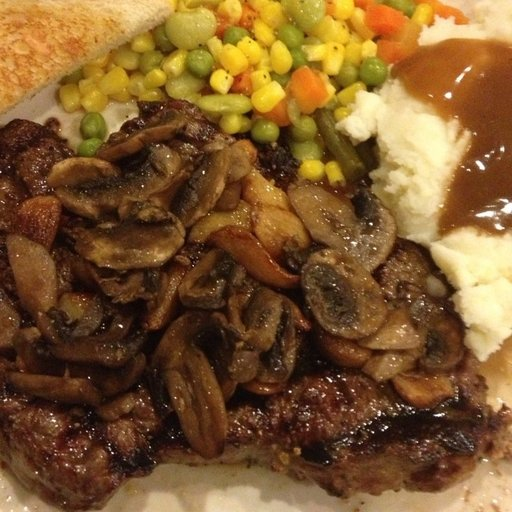

In [32]:
img = Image.open(test_dir / '005YYST06V93A.jpg')
img

In [35]:
weights.transforms()(img).unsqueeze(0).shape

torch.Size([1, 3, 480, 480])

In [39]:
idx_to_class = {j:i for i, j in data.class_to_idx.items()}
idx_to_class

{0: 'baklava',
 1: 'caesar_salad',
 2: 'cheese_sandwich',
 3: 'cheesecake',
 4: 'chicken_curry',
 5: 'chicken_wings',
 6: 'chocolate_cake',
 7: 'donuts',
 8: 'eggs',
 9: 'falafel',
 10: 'fish',
 11: 'french_fries',
 12: 'hamburger',
 13: 'hot_dog',
 14: 'ice_cream',
 15: 'lasagna',
 16: 'omelette',
 17: 'pizza',
 18: 'spaghetti',
 19: 'steak',
 20: 'sushi'}

In [43]:
def predict(model: torch.nn.Module,
            transform: torchvision.transforms,
            data_path,
            file_name: str):

    img = Image.open(data_path / file_name)

    X = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.inference_mode():
        y_logit = model(X)
        y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1).item()

        return idx_to_class[y_pred]


predict(model=model, transform=weights.transforms(), data_path=test_dir, file_name='005YYST06V93A.jpg')

'steak'

In [51]:
predict(model=model, transform=weights.transforms(), data_path=test_dir, file_name='005YYST06V93A.jpg')

'steak'

In [44]:
test_dir

PosixPath('data/food/food/test')

In [46]:
type(os.listdir(test_dir))

list

In [53]:
df = pd.DataFrame(data=os.listdir(test_dir), columns=['file'])
df['prediction'] = df['file'].apply(lambda x: predict(model=model, transform=weights.transforms(), data_path=test_dir, file_name=x))

In [54]:
len(df)

4276

In [55]:
df.head(3)

,file,prediction
0,8LUN2VVIZB6A7.jpg,spaghetti
1,KA52UIHS4GDZ8.jpg,caesar_salad
2,KKMW8U05WQJLH.jpg,falafel


In [56]:
df.to_csv('output.csv')